In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


In [2]:
train_transforms = transforms.Compose([
    transforms.RandomRotation((-7,7), fill=(1,)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomCrop(size=28),
    # transforms.RandomResizedCrop(size=28),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))
])

test_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))])

In [3]:
train_data = datasets.MNIST(root="data", train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST(root="data",train=False, download=True, transform=test_transforms)

In [4]:
SEED =  42
cuda  = torch.cuda.is_available()
torch.manual_seed(SEED)
dataloader_args = dict(shuffle=True, batch_size= 64, num_workers=4, pin_memory=True)  if cuda else dict(shuffle=True, batch_size=64)

train_loader = torch.utils.data.DataLoader(train_data,**dataloader_args)
test_loader = torch.utils.data.DataLoader(test_data,**dataloader_args)

In [5]:
train_iter = iter(train_loader)

In [6]:
train_batch = next(train_iter)

In [7]:
imgs, labels = train_batch

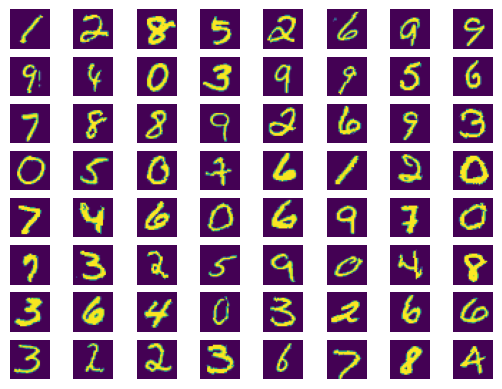

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure()
sub_plt = fig.subplots(8,8)
no_of_images = 64
sub_plt_imgs = imgs[0:64]
total = 0
for i in range(8):
    for j in range(8):
        sub_plt[i][j].imshow(sub_plt_imgs[total].numpy().squeeze())
        sub_plt[i][j].axis("off")
        total += 1


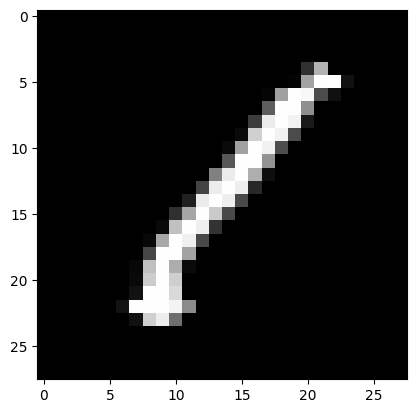

In [9]:
plt.imshow(imgs[0].numpy().squeeze(),cmap="gray")

In [10]:
from model5_3 import Model
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model().to(device)
summary(model, input_size=(1, 28, 28))

Defaulting to user installation because normal site-packages is not writeable
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
              ReLU-2            [-1, 8, 26, 26]               0
           Dropout-3            [-1, 8, 26, 26]               0
       BatchNorm2d-4            [-1, 8, 26, 26]              16
            Conv2d-5           [-1, 10, 24, 24]             730
              ReLU-6           [-1, 10, 24, 24]               0
           Dropout-7           [-1, 10, 24, 24]               0
       BatchNorm2d-8           [-1, 10, 24, 24]              20
            Conv2d-9           [-1, 12, 22, 22]           1,092
             ReLU-10           [-1, 12, 22, 22]               0
          Dropout-11           [-1, 12, 22, 22]               0
      BatchNorm2d-12           [-1, 12, 22, 22]              24
        MaxPool2d-13


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [12]:
from torch.optim.lr_scheduler import StepLR

model =  Model().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.06, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.24160556495189667 Batch_id=937 Accuracy=94.86: 100%|██████████| 938/938 [00:15<00:00, 59.57it/s] 



Test set: Average loss: 0.0467, Accuracy: 9853/10000 (98.53%)

EPOCH: 1


Loss=0.011918066069483757 Batch_id=937 Accuracy=98.08: 100%|██████████| 938/938 [00:17<00:00, 54.13it/s] 



Test set: Average loss: 0.0438, Accuracy: 9865/10000 (98.65%)

EPOCH: 2


Loss=0.020747769623994827 Batch_id=937 Accuracy=98.36: 100%|██████████| 938/938 [00:17<00:00, 52.75it/s] 



Test set: Average loss: 0.0345, Accuracy: 9891/10000 (98.91%)

EPOCH: 3


Loss=0.005211899522691965 Batch_id=937 Accuracy=98.42: 100%|██████████| 938/938 [00:18<00:00, 50.07it/s] 



Test set: Average loss: 0.0299, Accuracy: 9909/10000 (99.09%)

EPOCH: 4


Loss=0.03544680029153824 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [00:18<00:00, 50.11it/s]  



Test set: Average loss: 0.0288, Accuracy: 9907/10000 (99.07%)

EPOCH: 5


Loss=0.19790437817573547 Batch_id=937 Accuracy=98.63: 100%|██████████| 938/938 [00:20<00:00, 46.72it/s]  



Test set: Average loss: 0.0262, Accuracy: 9921/10000 (99.21%)

EPOCH: 6


Loss=0.1362220048904419 Batch_id=937 Accuracy=98.78: 100%|██████████| 938/938 [00:18<00:00, 49.69it/s]   



Test set: Average loss: 0.0215, Accuracy: 9922/10000 (99.22%)

EPOCH: 7


Loss=0.15598958730697632 Batch_id=937 Accuracy=98.78: 100%|██████████| 938/938 [00:19<00:00, 48.96it/s]  



Test set: Average loss: 0.0251, Accuracy: 9918/10000 (99.18%)

EPOCH: 8


Loss=0.011432843282818794 Batch_id=937 Accuracy=98.91: 100%|██████████| 938/938 [00:19<00:00, 49.08it/s] 



Test set: Average loss: 0.0235, Accuracy: 9921/10000 (99.21%)

EPOCH: 9


Loss=0.01668332703411579 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [00:18<00:00, 50.03it/s]   



Test set: Average loss: 0.0213, Accuracy: 9925/10000 (99.25%)

EPOCH: 10


Loss=0.011514215730130672 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:18<00:00, 49.98it/s]  



Test set: Average loss: 0.0270, Accuracy: 9922/10000 (99.22%)

EPOCH: 11


Loss=0.011344470083713531 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [00:19<00:00, 49.19it/s] 



Test set: Average loss: 0.0222, Accuracy: 9930/10000 (99.30%)

EPOCH: 12


Loss=0.011892304755747318 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:18<00:00, 49.68it/s] 



Test set: Average loss: 0.0222, Accuracy: 9936/10000 (99.36%)

EPOCH: 13


Loss=0.0038207918405532837 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:18<00:00, 50.55it/s] 



Test set: Average loss: 0.0208, Accuracy: 9938/10000 (99.38%)

EPOCH: 14


Loss=0.003434790065512061 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:19<00:00, 49.12it/s]  



Test set: Average loss: 0.0215, Accuracy: 9932/10000 (99.32%)

